**Analyzing the effects of different risk factors on the presence of heart disease in patients**

_Ethan Coates_

Heart disease is a term describing several heart conditions putting afflicted patients at risk for serious consequences such as heart attacks, heart failure, and arrhythmia. Heart disease is known to have risk factors, with the 3 major ones (high blood pressure, high cholesterol and smoking) affecting a whopping 47% of the American population. Through the use of data science techniques, it is possible to gain further insight into how heavily the many risk factors of heart disease weigh in on each other and on the occurrence of heart disease.

We will be analyzing a dataset derived from the CDC's 2020 survey of approximately 400,000 American adults on their health and lifestyle as part of the BRFSS, or Behavioral Risk Factor Surveillance System. The BRFSS surveys, conducted in the United States since 1984, question respondees via phone. The original dataset from the survey contained 279 columns with each representing a different question each row (respondee) was asked. 

This public domain dataset maintains all 401,958 rows of the original but strips the large number of questions down to 18. One of these is if the patient reported heart disease, and the rest are questions about other lifestyle choices and health conditions that may have an effect on whether the patient suffers from heart disease or not. The dataset is available as a CSV (comma-separated values) table, so we'll begin by importing it into a dataframe using PANDAS, a Python library highly optimized for efficiently working with datasets.

The Dataset: 

https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

Information on Heart Disease: 

https://www.cdc.gov/heartdisease/risk_factors.htm

https://www.cdc.gov/heartdisease/about.htm

In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score


df = pd.read_csv("heart_2020_cleaned.csv")

df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


The dataframe has named columns with various types of entries; yes/no questions, categorical questions such as race, and quantitative metrics such as BMI.

The database's description on Kaggle formally defines what the responses to each of these questions mean:

| HeartDisease | BMI | Smoking | AlcoholDrinking | Stroke | PhysicalHealth | MentalHealth | DiffWalking | Sex 
| --- | --- | --- | --- | --- | --- | --- | --- | --- 
| Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI) | Body Mass Index (BMI) | Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] | Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week | (Ever told) (you had) a stroke? | Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 was your physical health not good? | Thinking about your mental health, for how many days during the past 30 days was your mental health not good? | Do you have serious difficulty walking or climbing stairs? | Are you male or female? 



| AgeCategory | Race | Diabetic | PhysicalActivity | GenHealth | SleepTime | Asthma | KidneyDisease | SkinCancer
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Fourteen-level age category | Imputed race/ethnicity value | (Ever told) (you had) diabetes? | Adults who reported doing physical activity or exercise during the past 30 days other than their regular job | Would you say that in general your health is... | On average, how many hours of sleep do you get in a 24-hour period? | (Ever told) (you had) asthma? | Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease? | (Ever told) (you had) skin cancer? |



In [336]:
print(df.dtypes)

HeartDisease         object
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object


When importing the CSV table, PANDAS did not assign specific data types to the non-numeric columns; instead, it is representing them as generic object types. We can begin to form a properly typed dataframe by peeking into each column and deciding on the appropriate representation ourselves.

In [337]:
f1 = df["PhysicalHealth"].unique()
f2 = df["MentalHealth"].unique()
f3 = df["SleepTime"].unique()
floats = [(f1, df["PhysicalHealth"].name), (f2, df["MentalHealth"].name), (f3, df["SleepTime"].name)]

for (f,n) in floats:
    non_int = False
    for val in f:
        if not (float(val).is_integer()): #Check if any numerical float values in the column have data past the decimal point (and thus should not be truncated)
            non_int = True
    if non_int:
        print(str(n) + " contains at least one non-int float value.")
    else:
        print(str(n) + " contains only integer values.")

df["PhysicalHealth"] = pd.to_numeric(df["PhysicalHealth"], downcast="integer")
df["MentalHealth"] = pd.to_numeric(df["MentalHealth"], downcast="integer")
df["SleepTime"] = pd.to_numeric(df["SleepTime"], downcast="integer")

PhysicalHealth contains only integer values.
MentalHealth contains only integer values.
SleepTime contains only integer values.


When looking at the descriptors for PhysicalHealth and MentalHealth, we can see that the responses are in numbers of days. For SleepTime, the reponse is in hours. These columns were assigned as floating-point types, but performing a check on each of them reveals that they are all integers anyway (nothing past the right of the decimal point). So, we can convert them.

In [338]:
cn = ["HeartDisease", "Smoking", \
"AlcoholDrinking", "Stroke", "DiffWalking", \
"PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]

i = 0
for col_name in cn:
    temp_name = "temp" + str(i)
    df[temp_name] = False #Temporary column to replace the current one
    mask = df[col_name] == "Yes"
    df.loc[mask,temp_name] = True #"Yes" should map to True, and "No" should stay as false
    df.drop(columns=[col_name], inplace=True)
    df.rename(columns = {temp_name: col_name}, inplace=True)
    i += 1

Yes/no questions were logged as either "Yes" or "No", so we can convert those columns into boolean. While it is possible to use the apply() function in Pandas to convert "Yes" into True (and "No" into False), it is very inefficient on large datasets like this. So, a vectorized solution is preferred, where a new column of all False values is created and the "Yes" values found in the original column are "masked" over the new one. Vectorized code like this allows for under-the-hood optimizations by Pandas to take place, reducing the runtime dramatically (in this case, 0.4 vs. 18 seconds!).

In [339]:
cn = ["GenHealth", "Sex", "AgeCategory", "Race", "Diabetic"]

for col_name in cn:
    print(df[col_name].unique())


['Very good' 'Fair' 'Good' 'Poor' 'Excellent']
['Female' 'Male']
['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29']
['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic']
['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)']


For our categorical columns, we have the ability to convert them to a special categorical type in Pandas. The goal here is to assign each observation into a predefined bin; above, we can see all of the unique bins for each column. Importantly, this categorical type supports both ordered and unordered bins. Race, Sex and Diabetic should be unordered, but it makes sense for GenHealth and AgeCategory to be ordered, from worst to best and youngest to oldest respectively.

In [340]:
sorted_age_cat = np.sort(df["AgeCategory"].unique())
sorted_gen_health = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']

df["AgeCategory"] = pd.Categorical(df["AgeCategory"], ordered=True, categories=sorted_age_cat) #Ordered category
df["GenHealth"] = pd.Categorical(df["GenHealth"], ordered=True, categories=sorted_gen_health)
df["Sex"] = df["Sex"].astype("category") #Unordered category
df["Race"] = df["Race"].astype("category")
df["Diabetic"] = df["Diabetic"].astype("category")
df.dtypes

BMI                  float64
PhysicalHealth          int8
MentalHealth            int8
Sex                 category
AgeCategory         category
Race                category
Diabetic            category
GenHealth           category
SleepTime               int8
HeartDisease            bool
Smoking                 bool
AlcoholDrinking         bool
Stroke                  bool
DiffWalking             bool
PhysicalActivity        bool
Asthma                  bool
KidneyDisease           bool
SkinCancer              bool
dtype: object

Finally, we have assigned proper types to all of the columns, which will facilitate our data analysis by making it more straightforward to plot things; this completes the "data representation" stage of our pipeline. This process should also make data operations quicker.

We can start our data analysis by plotting out the distribution of the numerical variables BMI, PhysicalHealth, MentalHealth, and SleepTime among patients that reported heart disease and those that did not. We will use violin plots, as they show the modality more clearly, and will be much easier than box plots to interpret since we're working with so many samples; displaying tens of thousands of datapoints at once will be too difficult to view.

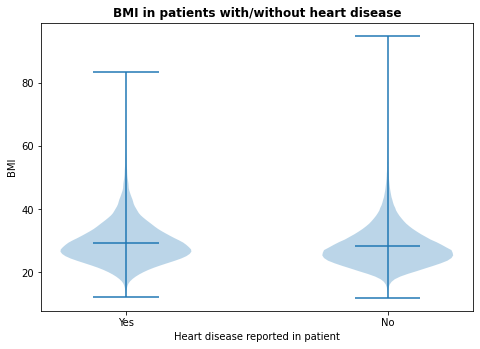

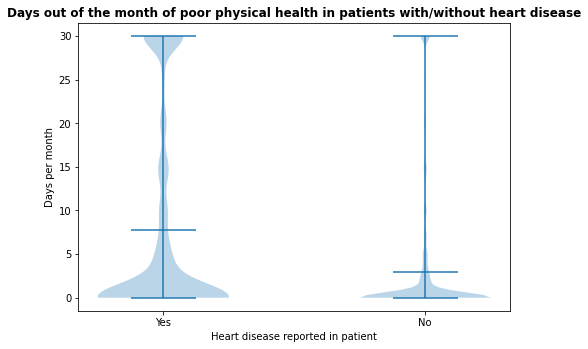

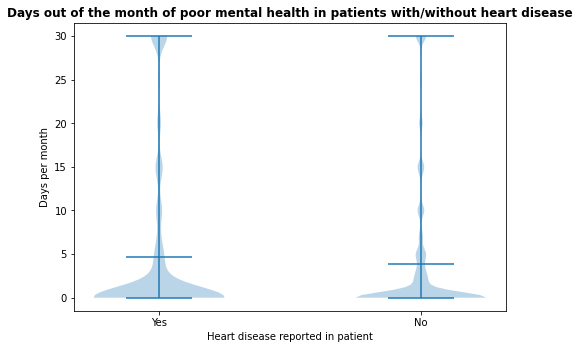

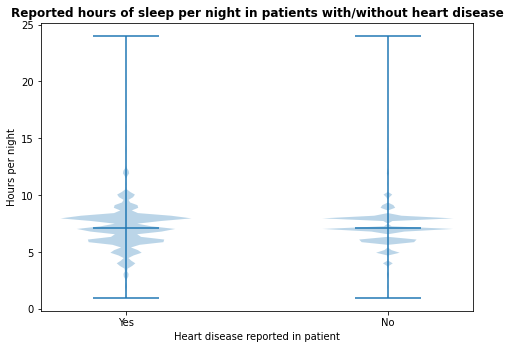

In [341]:
nv = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
nv_titles = {'BMI' : "BMI in patients with/without heart disease", 'PhysicalHealth' : "Days out of the month of poor physical health in patients with/without heart disease",\
    'MentalHealth' : "Days out of the month of poor mental health in patients with/without heart disease", \
    'SleepTime' : "Reported hours of sleep per night in patients with/without heart disease"}
nv_labels = {'BMI' : "BMI", 'PhysicalHealth' : "Days per month", 'MentalHealth' : "Days per month", 'SleepTime' : "Hours per night"}
for v in nv:
    fig = plt.figure()
    data = [(df.loc[df['HeartDisease'] == True])[v], (df.loc[df['HeartDisease'] == False])[v]] #Left plot: column where HD is true. Right plot: column where HD is false
    ax = fig.add_axes([0,0,1,1])
    ax.set_xticks([1,2])
    ax.set_xticklabels(["Yes", "No"])
    ax.set_xlabel("Heart disease reported in patient")
    ax.set_ylabel(nv_labels[v])
    ax.set_title(nv_titles[v], fontweight='bold')
    bp = ax.violinplot(data, showmeans=True)
    plt.show()


From looking at these, it is already possible to draw some basic conclusions about these variables. Interestingly, BMI means and distributions appear to be almost identical between afflicted and non-afflicted respondees. The same can be said about the number of hours of sleep per night reported and the number of days of poor mental health. 

However, heart disease sufferers report more days out of the month with worse physical health, with a sizable portion reporting poor physical health nearly every day of the month; for heart disease sufferers, the distribution of self-reported physical health is bimodal.

For the "binary" questions (yes/no answers or out of two groups, i.e. male/female), it makes sense to plot pie charts that tell us the proportions of each group (HD sufferers vs. non-HD sufferers) that answered yes/no to these questions.

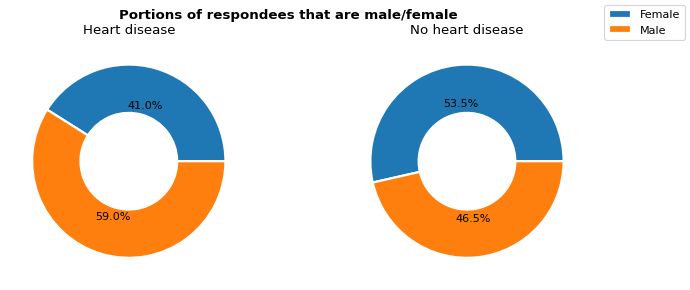

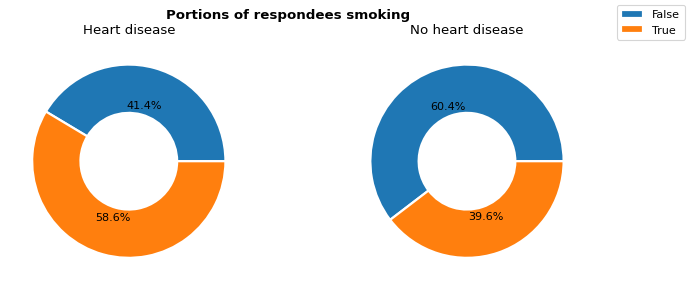

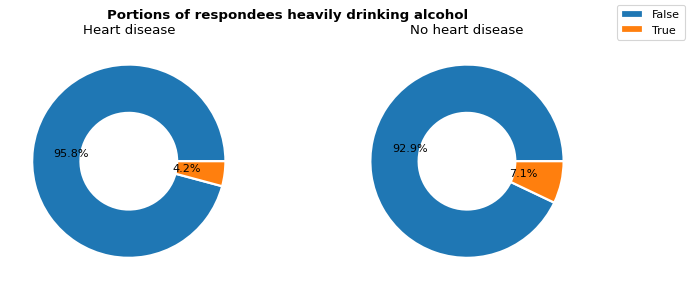

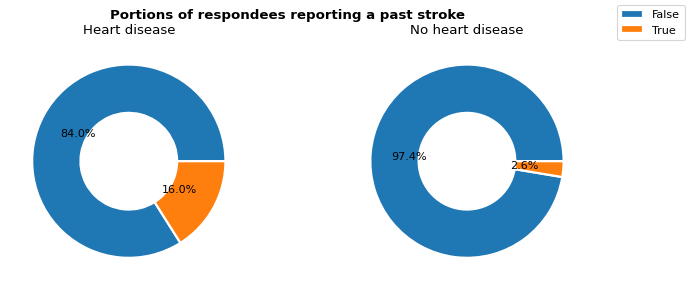

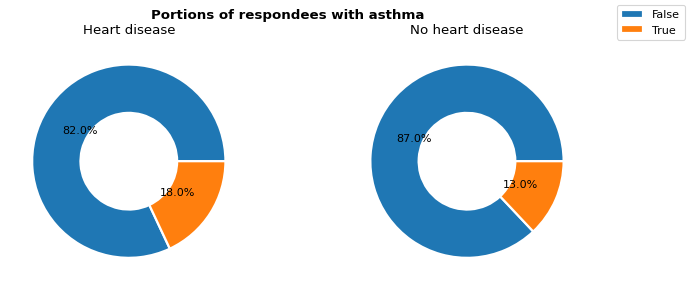

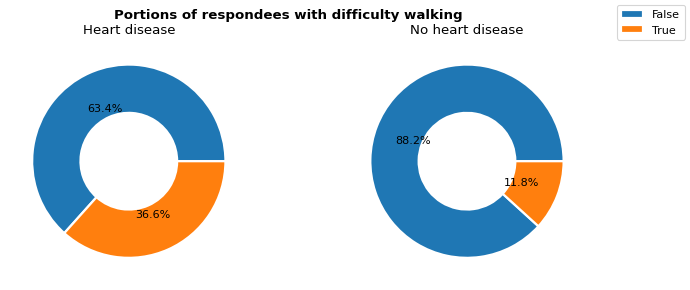

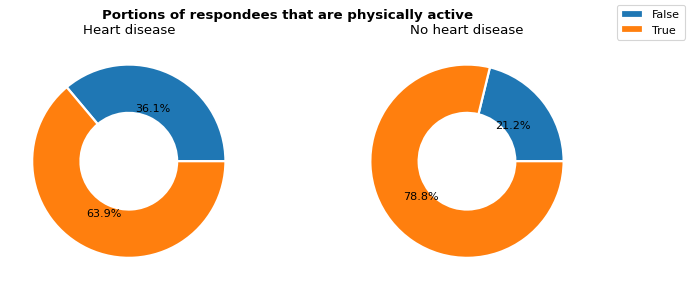

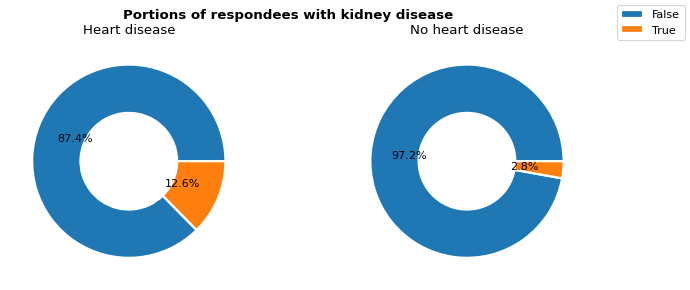

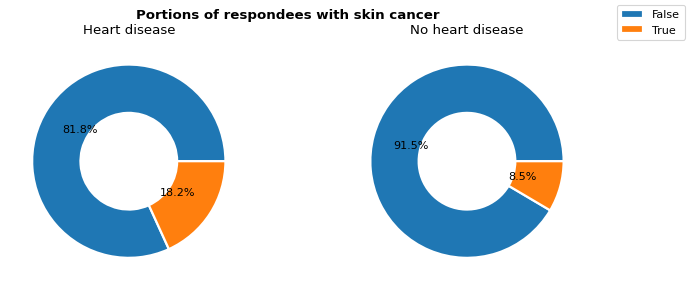

In [342]:
bv = ['Sex', 'Smoking','AlcoholDrinking','Stroke','Asthma', 'DiffWalking','PhysicalActivity','KidneyDisease','SkinCancer']
bv_titles = {'Sex' : 'that are male/female', 'Smoking' : 'smoking', 'AlcoholDrinking' : 'heavily drinking alcohol', 'Stroke' : 'reporting a past stroke', 'Asthma' : 'with asthma', 'DiffWalking' : 'with difficulty walking', \
    'PhysicalActivity' : 'that are physically active', 'KidneyDisease' : 'with kidney disease', 'SkinCancer' : 'with skin cancer'}

for v in bv:
    fig = plt.figure(figsize=(10,4), dpi=80)
    ax = plt.subplot(1,2,1)
    (df.loc[df['HeartDisease'] == True]).groupby(df[v]).HeartDisease.count().plot(kind="pie", autopct='%.1f%%', labeldistance=None,\
    wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white', 'width':0.5 })
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.title("Heart disease")

    ax2 = plt.subplot(1,2,2)
    (df.loc[df['HeartDisease'] == False]).groupby(df[v]).HeartDisease.count().plot(kind="pie", autopct='%.1f%%', labeldistance=None,\
     wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white', 'width':0.5 })
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.title("No heart disease")
    plt.suptitle("Portions of respondees " + bv_titles[v], fontweight='bold')

    h,l = ax.get_legend_handles_labels()
    leg = fig.legend(h, l, loc = 'upper right')
    plt.show()


From the pie charts plotted above, we can see that heart disease is slightly overrepresented in males versus females. There is nearly a 20% increase in smokers among those with heart disease than in non-HD respondees. HD respondees had a greater rate of some other ailments (skin cancer, kidney disease, and strokes). 

The most prominent differences between the two groups was in having difficulty walking (36% vs. 11%) and being physically active (63% vs. 78%), for HD and non-HD respectively.

One important thing to note here is that these charts alone cannot tell us that any of these factors **cause** heart disease or are direct symptoms of it; we can only say that they are **associated** with each other.

A compact way to display the relation between HD and the categorical variables (Age, race, general health) is by using bar graphs, where each pair of bars represents the percentage of responses from HD/non-HD patients for that category.

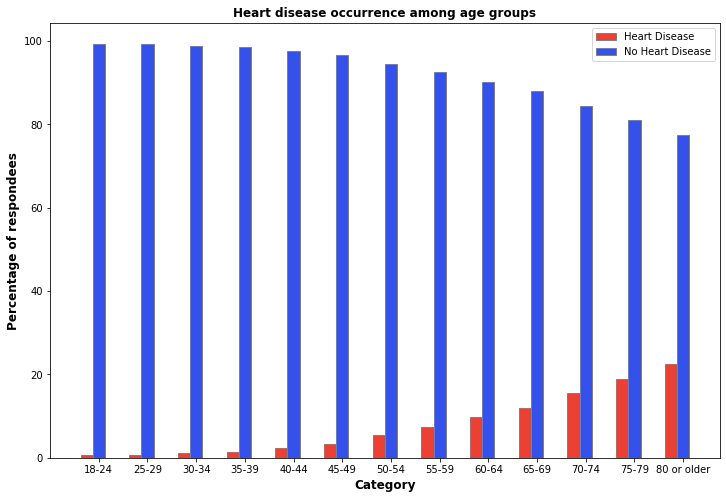

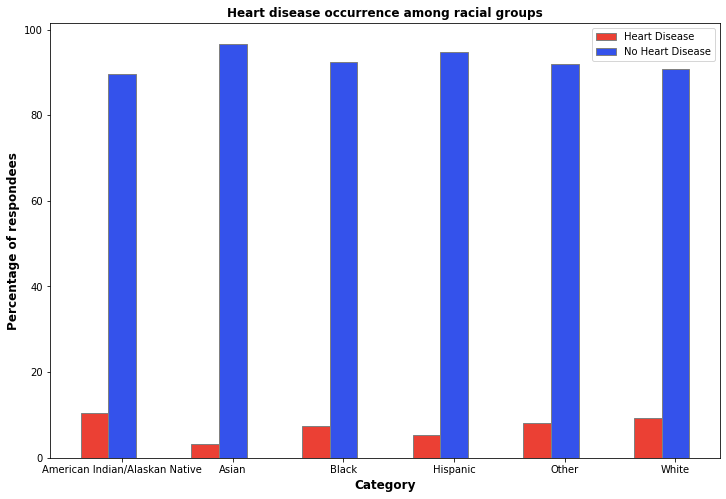

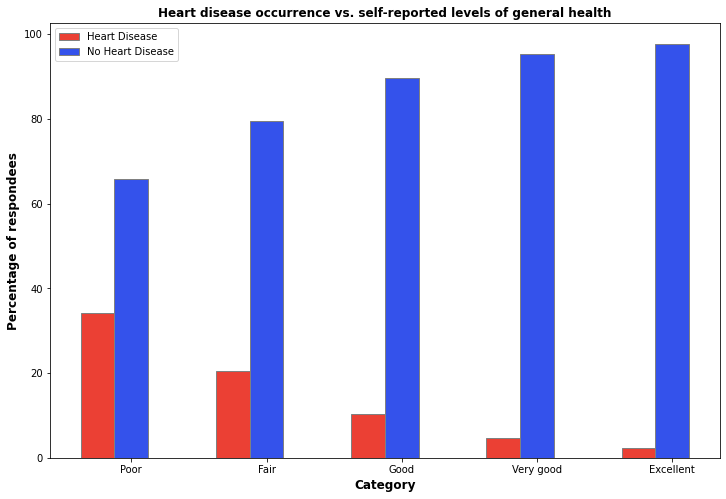

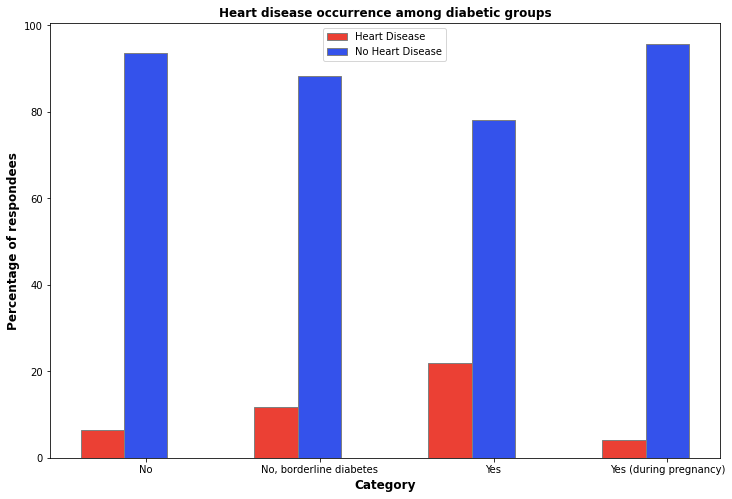

In [343]:
cv = ['AgeCategory','Race', 'GenHealth', 'Diabetic']
cv_titles = {'AgeCategory' : 'Heart disease occurrence among age groups', 'Race' : 'Heart disease occurrence among racial groups', \
    'GenHealth' : 'Heart disease occurrence vs. self-reported levels of general health', 'Diabetic' : 'Heart disease occurrence among diabetic groups'}
for v in cv:
    barWidth = 0.25
    fig = plt.subplots(figsize =(12, 8))
    hd = [] #Array of data for all HD patients
    nhd = [] #Array of data for all non-HD patients
    for c in df[v].cat.categories:
        total = df.groupby(df[v]).HeartDisease.count()[c]
        hd.append((((df.loc[df['HeartDisease'] == True]).groupby(df[v]).HeartDisease.count()[c])/total) * 100)
        nhd.append((((df.loc[df['HeartDisease'] == False]).groupby(df[v]).HeartDisease.count()[c])/total) * 100)

    br1 = np.arange(len(df[v].cat.categories))
    br2 = [x + barWidth for x in br1] # Bars get plot out individually, separated by barWidth
    plt.bar(br1, hd, color ='#eb4034', width = barWidth,
        edgecolor ='grey', label ='Heart Disease')
    plt.bar(br2, nhd, color ='#3452eb', width = barWidth,
        edgecolor ='grey', label ='No Heart Disease')
    
    plt.xlabel('Category', fontweight ='bold', fontsize = 12)
    plt.ylabel('Percentage of respondees', fontweight ='bold', fontsize = 12)
    plt.xticks([r + barWidth for r in range(len(df[v].cat.categories))],
        df[v].cat.categories)
    plt.title(cv_titles[v], fontweight='bold')
    plt.legend()
    plt.show()


As the age group of respondees increases, the ratio of those with heart disease does as well. Another majorly related variable was self-reported general health, with those considering themselves to be in poorer health reporting HD more often. This could possibly explain why diabetes patients had higher rates of heart disease as well. Race does not seem to play a major role, but Asians and Hispanics had a slightly lower rate than others.

We have performed a good amount of EDA (exploratory data analysis) on this dataset. Next, we will use this data to train, validate, and compare several different classification algorithms. Scikit-Learn will be the library of choice, as it is widely supported and contains all of the utilities we need.

The overall question here is "Can we use this dataset to predict if a respondee has heart disease?"

Before we do anything else, we have to transform the dataframe again. In order to train the algorithms with our data, everything must be numeric. For binary variables, True is 1 and False is 0. For categorical variables, we can use two types of encoding, depending on whether the category is ordered or not. These are "one hot" encoding (create a new binary column for each category in an unordered categorical variable) and ordinal encoding (assign increasing numbers for each category in an ordered categorical variable). The library category_encoders automates this process.

Categorical data encoding:

https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

In [344]:
bc = ['HeartDisease','Sex','Smoking','SkinCancer','Stroke','Asthma', 'DiffWalking','PhysicalActivity','KidneyDisease','AlcoholDrinking']

for c in bc:
    df[c] = df[c].replace([False,True],[0,1])

# List of encoder objects for each column
encoding_stages = [ce.OneHotEncoder(cols='Sex', return_df=True, use_cat_names=True), ce.OneHotEncoder(cols='Race', return_df=True, use_cat_names=True), ce.OneHotEncoder(cols='Diabetic', return_df=True, use_cat_names=True), \
ce.OrdinalEncoder(cols=['AgeCategory'], return_df=True, mapping=[{'col':'AgeCategory', 'mapping': {'18-24':1, '25-29':2,'30-34':3,'35-39':4,'40-44':5,'45-49':6,'50-54':7,'55-59':8,'60-64':9,'65-69':10,'70-74':11,'75-79':12,'80 or older':13}}]), \
ce.OrdinalEncoder(cols=['GenHealth'], return_df=True, mapping=[{'col':'GenHealth', 'mapping':{'Poor':1,'Fair':2,'Good':3,'Very good':4,'Excellent':5}}])]

for encoder in encoding_stages:
    df = encoder.fit_transform(df)

df.head()

,BMI,PhysicalHealth,MentalHealth,Sex_Female,Sex_Male,AgeCategory,Race_White,Race_Black,Race_Asian,Race_American Indian/Alaskan Native,...,SleepTime,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,PhysicalActivity,Asthma,KidneyDisease,SkinCancer
0,16.60,3,30,1,0,8,1,0,0,0,...,5,0,1,0,0,0,1,1,0,1
1,20.34,0,0,1,0,13,1,0,0,0,...,7,0,0,0,1,0,1,0,0,0
2,26.58,20,30,0,1,10,1,0,0,0,...,8,0,1,0,0,0,1,1,0,0
3,24.21,0,0,1,0,12,1,0,0,0,...,6,0,0,0,0,0,0,0,0,1
4,23.71,28,0,1,0,5,1,0,0,0,...,8,0,0,0,0,1,1,0,0,0


For certain classification/machine learning models, the data will need to be normalized. This means scaling numeric columns so that the range of the data is restricted between 0 and 1, where the minimum value becomes 0 and the maximum becomes 1, and the others are scaled proportionally to the minimum and maximum. SKLearn provides functionality for this type of normalization, called min-max scaling.

https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

In [345]:
col_names = df.columns
normalized_values = MinMaxScaler().fit_transform(df) #Returns an array

df = pd.DataFrame(normalized_values, columns = col_names) #Convert the array back into a dataframe, using original column names
df.head()

,BMI,PhysicalHealth,MentalHealth,Sex_Female,Sex_Male,AgeCategory,Race_White,Race_Black,Race_Asian,Race_American Indian/Alaskan Native,...,SleepTime,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,PhysicalActivity,Asthma,KidneyDisease,SkinCancer
0,0.055294,0.100000,1.0,1.0,0.0,0.583333,1.0,0.0,0.0,0.0,...,0.173913,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,0.100447,0.000000,0.0,1.0,0.0,1.000000,1.0,0.0,0.0,0.0,...,0.260870,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.175782,0.666667,1.0,0.0,1.0,0.750000,1.0,0.0,0.0,0.0,...,0.304348,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.147169,0.000000,0.0,1.0,0.0,0.916667,1.0,0.0,0.0,0.0,...,0.217391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.141132,0.933333,0.0,1.0,0.0,0.333333,1.0,0.0,0.0,0.0,...,0.304348,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


There is one more issue to take care of before training our models. As stated in the description of the dataset, the classes (in this case, heart disease or no heart disease) are unbalanced:

In [346]:
print(df.loc[df['HeartDisease'] == 1].shape[0])
print(df.loc[df['HeartDisease'] == 0].shape[0])

27373
292422


There are about 10 times more non-HD respondees than HD respondees. This is a problem because if we were to train a model on this data, it would not generalize very well. This can be corrected through a process called oversampling/resampling, where random rows of data are duplicated until the undersampled class has the same number of rows as the other class. SKLearn also provides resampling functionality.

Class balancing:

https://thecleverprogrammer.com/2021/04/25/class-balancing-in-machine-learning/

In [347]:
hd = df[df['HeartDisease'] == 1]
non_hd = df[df['HeartDisease'] == 0]

resampled_hd = resample(hd, n_samples=non_hd.shape[0], random_state=1) #Resample data for HD patients

df = pd.concat([non_hd, resampled_hd]) #Put the oversampled data back into the dataframe

The first model we will train will be a logistic regression model; it is similar to linear regression but is formulated to support binary classification. To do this, we will split the dataframe into independent and dependent variables (in this case, independent will be all of the factors we explored earlier, and the dependent variable will be the patient's heart disease status). Then, we split the data into a training and testing set, where the training data is used to fit the model and the testing set is used to test the model's accuracy.

https://www.analyticsvidhya.com/blog/2020/12/beginners-take-how-logistic-regression-is-related-to-linear-regression/

In [348]:
ind = [x for x in df.columns if x != 'HeartDisease']
dep = ['HeartDisease']
ind_train, ind_test, dep_train, dep_test = train_test_split(df[ind], df[dep], random_state=1)

lg_model = LogisticRegression()
lg_model.fit(ind_train, pd.Series.ravel(dep_train))
lg_predictions = lg_model.predict(ind_test)

The model is fitted. Now, we can see how accurate it was at predicting heart disease in the testing set by using a confusion matrix. The diagonal entries represent the number of correct guesses for each label.

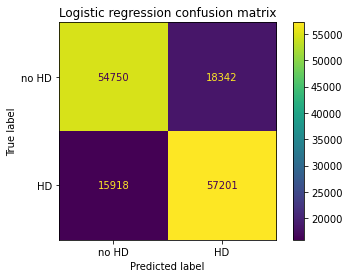

In [349]:
cm = confusion_matrix(pd.Series.ravel(dep_test), lg_predictions, labels=lg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no HD', 'HD'])
disp.plot()
plt.title("Logistic regression confusion matrix")
plt.show()

So, we have seen the accuracy for one testing set, but does this level of accuracy generalize for any testing set? We can answer this with K-fold cross validation. This process will re-train the model and re-test its accuracy for K different splits of training/testing data. Each fold generates an accuracy score; we'll take the average.

In [350]:
kf = KFold(n_splits=10)
cv_score = cross_val_score(lg_model, df[ind], pd.Series.ravel(df[dep]), cv=kf)
print('Logistic regression, average score across 10 folds: ' + str(np.mean(cv_score)))

Logistic regression, average score across 10 folds: 0.7107126933445347


This indicates that the logistic regression model achieved 71% accuracy on average. We'll repeat this entire process on another classifier (a decision tree) to see if this can be improved.

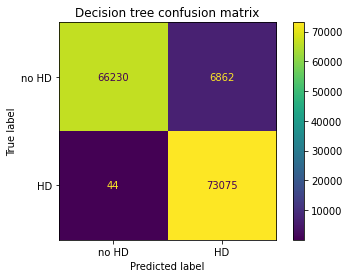

In [351]:
ind_train, ind_test, dep_train, dep_test = train_test_split(df[ind], df[dep], random_state=1)

dt_model = DecisionTreeClassifier()
dt_model.fit(ind_train, pd.Series.ravel(dep_train))
dt_predictions = dt_model.predict(ind_test)

cm = confusion_matrix(pd.Series.ravel(dep_test), dt_predictions, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no HD', 'HD'])
disp.plot()
plt.title("Decision tree confusion matrix")
plt.show()

In [352]:
kf = KFold(n_splits=10)
cv_score = cross_val_score(dt_model, df[ind], pd.Series.ravel(df[dep]), cv=kf)
print('Decision tree, average score across 10 folds: ' + str(np.mean(cv_score)))

Decision tree, average score across 10 folds: 0.9545471573317272


Remarkably, the decision tree is a significant improvement over logistic regression, with around 95% accuracy. Both of the models seem to have a bias towards misclassifying non-HD patients as having HD (moreso in the decision tree). 

We have taken this dataset through the entire data science pipeline, from data collection to data representation, data analysis and formulating a hypothesis and verifying it. From all of the work shown here, we can conclude, for HD and non-HD respondees:

1. BMI, mental health and hours of sleep are not too different among the two groups. Physical health, however, is worse among HD respondees.
2. More males reported heart disease than females.
3. HD respondees had higher rates of smoking, but similar rates of drinking.
4. As the age groups of respondees increase, so do the rates of heart disease.
5. HD respondees had higher rates of other health issues (strokes, difficulty walking, diabetes, asthma, and cancer), with more considering themselves to be in poorer health.

We can also confirm that the questions asked to respondees are sufficient for classification algorithms to predict a patient's heart disease status at around 95% accuracy (with our decision tree). Although the accuracy of this model was high (and we cross-validated it for 10 different training/testing sets), we cannot confirm that it will generalize well to large amounts of new data. Oversampling was required to train the classifier, as there was a lack of heart-disease positive respondees. For instance, this model might not have the same level of accuracy in different countries (i.e. what would happen if our racial makeup was changed?).

Thank you for reading this tutorial!